# AquaPredict

## Dataset Information

### Location:
An Internet of Things Labelled Dataset for Aquaponics Fish Pond Water Quality Monitoring System,
HiPIC Research Group, Department of Computer Science, University of Nigeria Nsukka, Nigeria
Click here for more details

### Contact:
Collins Udanor, email: collins.udanor@unn.edu.ng
Blessing Oguokiri, email: blessing.ogbuokiri@unn.edu.ng

### Dataset Information:
Aquaponics meta-data
The enclosed datasets are generated from freshwater aquaponics catfish ponds. The datasets are generated automatically at 5 seconds intervals using the following water quality sensors driven by the ESP 32 microcontroller: Dallas Instrument Temperature sensor (DS18B20), DF Robot Turbidity sensor, DF Robot Dissolved Oxygen sensor, DF Robot pH sensor V2.2, MQ-137 Ammonia sensor, and MQ-135 Nitrate sensor.
The project is funded by the Lacuna Award for Agriculture in Sub-Saharan Africa 2020 under the management of the Meridian Institute Colorado, USA.
The datasets and results in this section were sensor readings from June to mid-October 2021. There are 12 datasets, each from 12 aquaponics catfish ponds. Each of the 12 ponds IoT unit has six sensors (temperature, turbidity, dissolved oxygen, pH, ammonia, nitrate). As of the time of this report each unit has generated over 170,000 instances. The datasets are downloaded at intervals, cleaned, and labelled.

#### The attributes are:
1) Date/Time
2) Temperature
3) Turbidity
4) Dissolved Oxygen (DO)
5) pH
6) Ammonia
7) Nitrate
8) Population of fish in the pond
9)Length of Fish
10) Weight of Fish

### Attribute Information:
All attributes are continuous

No statistics available, but suggest to standardise variables for certain uses (e.g. for use with classifiers that are NOT scale-invariant)

*NOTE:* Attributes 9 and 10 are class identifiers that can be used differently. For example, one may need to predict the length of the fish using the water quality parameters (2-7) or in addition to the population or stocking density (parameter 8). Similarly, the same can be done using the weight attribute.

Source: [https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets](https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import pd, plt, np

In [3]:
plt.rcParams['figure.figsize'] = (20, 5)

## Constants

In [4]:
OPTIMAL_WATER_TEMP = 24.5
OPTIMAL_BED_TEMP = 24.5

## Data

Take data from the first pond from [kaggle](https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets)

In [5]:
df = pd.read_csv("data/IoTpond1.csv", parse_dates=["created_at"])

C:\Users\Jack\anaconda3\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname CET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [6]:
df.drop(['entry_id', 'Turbidity(NTU)', 'Dissolved Oxygen(g/ml)', 'PH', 'Ammonia(g/ml)', 'Nitrate(g/ml)','Population', 'Fish_Length(cm)', 'Fish_Weight(g)'], axis=1, inplace=True, errors='ignore')

In [7]:
# create DatetimeIndex from created_at
df.index = df.created_at

In [8]:
df

,created_at,Temperature (C)
created_at,,
2021-06-19 00:00:05,2021-06-19 00:00:05,24.8750
2021-06-19 00:01:02,2021-06-19 00:01:02,24.9375
2021-06-19 00:01:22,2021-06-19 00:01:22,24.8750
2021-06-19 00:01:44,2021-06-19 00:01:44,24.9375
2021-06-19 00:02:07,2021-06-19 00:02:07,24.9375
...,...,...
2021-10-13 02:48:31,2021-10-13 02:48:31,26.5625
2021-10-13 03:17:36,2021-10-13 03:17:36,26.5625
2021-10-13 03:46:49,2021-10-13 03:46:49,26.5000


In [9]:
df.dtypes

created_at         datetime64[ns]
Temperature (C)           float64
dtype: object

In [10]:
df.describe(datetime_is_numeric=True)

,created_at,Temperature (C)
count,83126,83126.000000
mean,2021-07-21 16:09:26.662151424,24.573376
min,2021-06-19 00:00:05,-127.000000
25%,2021-07-01 01:54:57.750000128,24.125000
50%,2021-07-27 17:36:44,24.562500
75%,2021-08-08 13:36:09,24.937500
max,2021-10-13 04:14:22,27.750000
std,NaN,0.861532


Let assume that given parameter describe water temperature.

In [11]:
# rename columns Temperature (C) to temp_water
df.rename(columns={'Temperature (C)': 'temp_water'}, inplace=True)

In [12]:
# remove rows with temp_water == -127
df = df[df.temp_water != -127]

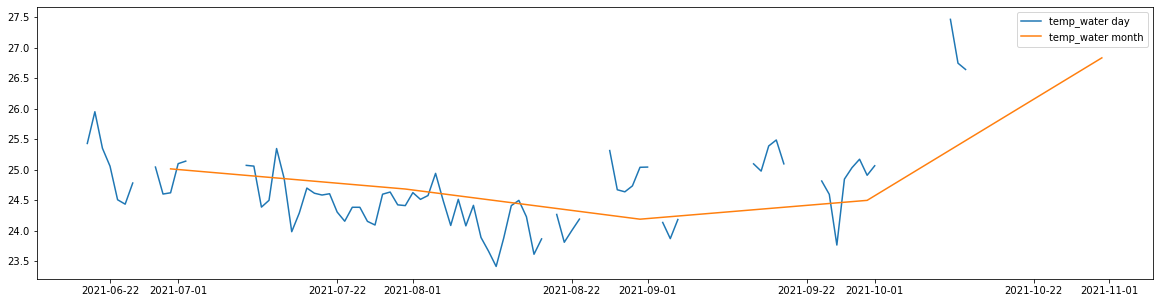

In [13]:
# show plot of temp_water. Agreggate by day. Plot as line chart
plt.plot(df.temp_water.resample('D').mean(), label='temp_water day')
plt.plot(df.temp_water.resample('M').mean(), label='temp_water month')
plt.legend()
plt.show()


Let ambient temperature be ranging from 21 to 29

[source](https://www.climatestotravel.com/climate/nigeria)

In [14]:
print(np.mean([21,29]))

25.0


Then ambient and the growbed temperature have higher variance.

In [15]:
# add simple moving average of temp_water from 3 days to df
df['temp_water_sma'] = df["temp_water"].rolling('3D').mean()

<ipython-input-15-8f28824197da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_water_sma'] = df["temp_water"].rolling('3D').mean()


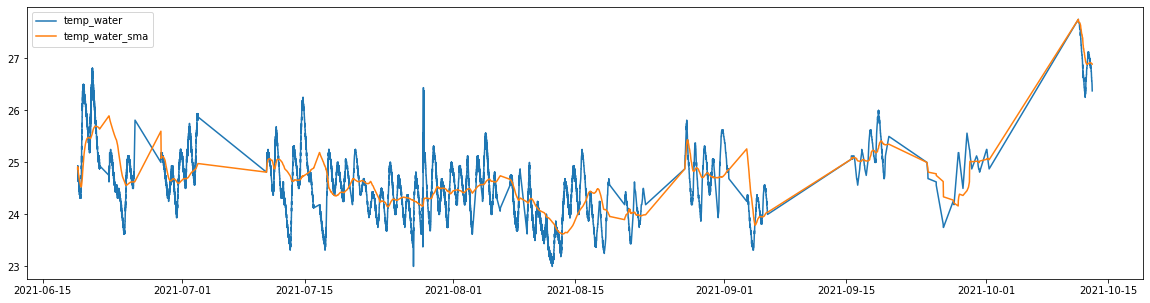

In [16]:
# plot temp_water and temp_water_sma
plt.plot(df.temp_water, label='temp_water')
plt.plot(df.temp_water_sma, label='temp_water_sma')
plt.legend()
# increase width of the graph
plt.show()

Amplify distance from `sma`

In [17]:
# Amplify distance from `sma` to `temp_water`
df['temp_bed'] = df['temp_water_sma'] + (df['temp_water'] - df['temp_water_sma']) * 2
df['temp_ambient'] = df['temp_water_sma'] + (df['temp_water'] - df['temp_water_sma']) * 3

<ipython-input-17-320dc85afe06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_bed'] = df['temp_water_sma'] + (df['temp_water'] - df['temp_water_sma']) * 2
<ipython-input-17-320dc85afe06>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp_ambient'] = df['temp_water_sma'] + (df['temp_water'] - df['temp_water_sma']) * 3


In [18]:
df.describe()

,temp_water,temp_water_sma,temp_bed,temp_ambient
count,83125.000000,83125.000000,83125.000000,83125.000000
mean,24.575199,24.567865,24.582533,24.589867
std,0.682535,0.496365,1.105889,1.586754
min,23.000000,23.624510,21.694683,20.076866
25%,24.125000,24.285687,23.767584,23.431991
50%,24.562500,24.567669,24.529879,24.505025
75%,24.937500,24.777902,25.249326,25.616525
max,27.750000,27.750000,28.654201,30.870902


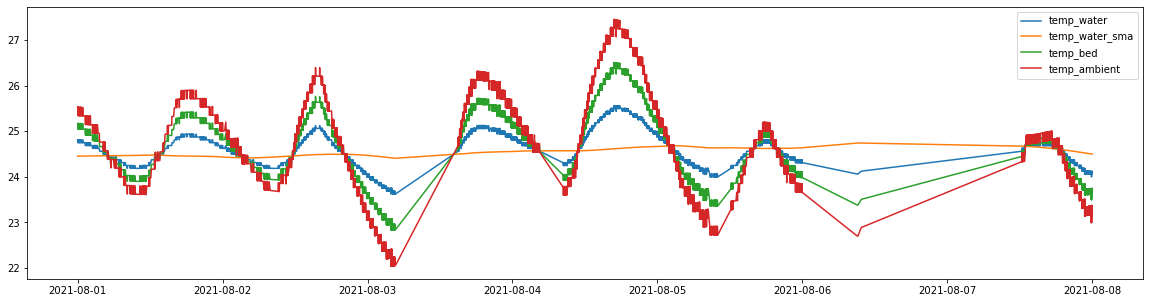

In [19]:
# get slice of df from 2021-08-01 to 2021-08-07
df_slice = df.loc['2021-08-01':'2021-08-07']
# plot temp_water and temp_water_sma and temp_bed and temp_ambient
plt.plot(df_slice.temp_water, label='temp_water')
plt.plot(df_slice.temp_water_sma, label='temp_water_sma')
plt.plot(df_slice.temp_bed, label='temp_bed')
plt.plot(df_slice.temp_ambient, label='temp_ambient')
plt.legend()

plt.show()

Add offset to water and growbad temperatures. Shifting using datetime is more precise but it would need interpolation to match indexes.

In [20]:
# shift temp_bed column by 3 hours
df_shift = df.shift(periods=3, freq='H')
left, right = df.align(df_shift, join='inner', axis=0)
left["temp_bed"] = right["temp_bed"]

# shift temp_water column by 5 hours
df_shift = df.shift(periods=5, freq='H')
left_2, right_2 = df.align(df_shift, join='inner', axis=0)
left_2["temp_water"] = right_2["temp_water"]

# shift by periods
df_shift_simple = df 
df_shift_simple["temp_bed"] = df["temp_bed"].shift(periods=200)
df_shift_simple["temp_water"] = df["temp_water"].shift(periods=400)

df_shifted = df_shift_simple

<ipython-input-20-7d6e016b0c57>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shift_simple["temp_bed"] = df["temp_bed"].shift(periods=200)
<ipython-input-20-7d6e016b0c57>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shift_simple["temp_water"] = df["temp_water"].shift(periods=400)


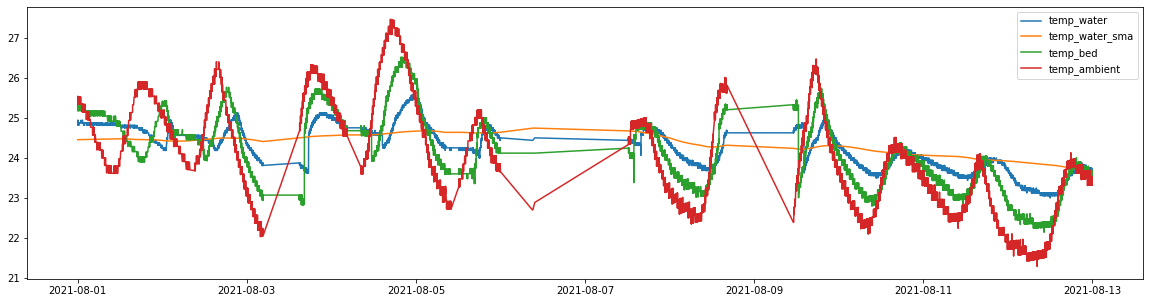

In [21]:
# get slice of df from 2021-08-01 to 2021-08-07
df_slice = df_shifted.loc['2021-08-01':'2021-08-12']
# plot temp_water and temp_water_sma and temp_bed and temp_ambient
plt.plot(df_slice.temp_water, label='temp_water' )
plt.plot(df_slice.temp_water_sma, label='temp_water_sma')
plt.plot(df_slice.temp_bed, label='temp_bed')
plt.plot(df_slice.temp_ambient, label='temp_ambient')

plt.legend()

In [22]:
# round data to nearest hour
df = df_shifted
df = df.resample('1H').mean()

Add heater values

In [23]:
# add column "water_heater" with 1 if temp_water < OPTIMAL_WATER_TEMP and 0 otherwise
df['water_heater'] = np.where(df['temp_water'] < OPTIMAL_WATER_TEMP, 1, 0).astype('int8')

<AxesSubplot:title={'center':'water_heater'}>

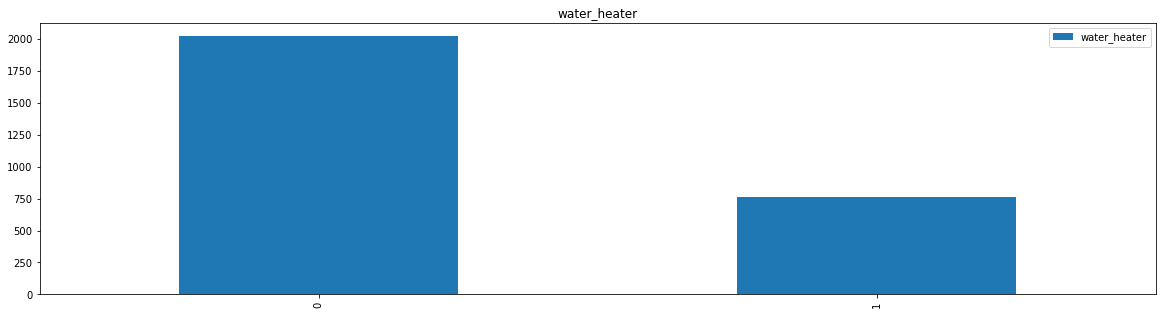

In [24]:
counts = pd.DataFrame(df["water_heater"].value_counts())
counts.plot(kind='bar', title='water_heater')

Save dataset in feather format

In [25]:
# remove index from df
import os
df.reset_index(inplace=True)
os.makedirs('tmp', exist_ok=True)
df.to_feather('tmp/aquaponics.feather')

In [26]:
#read data from file and remove NaN
df = pd.read_feather('tmp/aquaponics.feather')
df.index = df.created_at
col = ['temp_water', 'temp_water_sma', 'temp_bed', 'temp_ambient']

for column in col:
    df[column].fillna(value=df[column].mean(), inplace=True)
df

,created_at,temp_water,temp_water_sma,temp_bed,temp_ambient,water_heater
created_at,,,,,,
2021-06-19 00:00:00,2021-06-19 00:00:00,24.504824,24.880557,24.517797,24.794284,0
2021-06-19 01:00:00,2021-06-19 01:00:00,24.504824,24.820635,24.862102,24.549961,0
2021-06-19 02:00:00,2021-06-19 02:00:00,24.504824,24.767672,24.736911,24.415827,0
2021-06-19 03:00:00,2021-06-19 03:00:00,24.851799,24.719587,24.583745,24.223870,0
2021-06-19 04:00:00,2021-06-19 04:00:00,24.729779,24.673803,24.451579,24.115169,0
...,...,...,...,...,...,...
2021-10-13 00:00:00,2021-10-13 00:00:00,25.062500,26.913073,25.052498,26.611354,0
2021-10-13 01:00:00,2021-10-13 01:00:00,25.109375,26.910776,26.198897,26.428449,0
2021-10-13 02:00:00,2021-10-13 02:00:00,24.906250,26.903373,27.676336,26.044817,0


In [27]:
# split into data and decision variables
y = df.iloc[:, -1:].values
x = df.iloc[:, 1:-1].values

In [28]:
#split into training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 1/4, random_state = 0)

In [29]:
#scale data and feed into random forest
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 0)
rf.fit(x_train, y_train)
rfy_pred = rf.predict(x_test)

#linear regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)
lry_pred = lr.predict(x_test)

#SVC
from sklearn.svm import SVC
clf = SVC(kernel = 'linear')
clf.fit(x_train,y_train)

clf_pred = clf.predict(x_test)

<ipython-input-29-f5678b6415e1>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [30]:
from sklearn.metrics import accuracy_score
print(f'Random Forest: {accuracy_score(y_test, rfy_pred)}')
print("\n")
print(f'Logistic Regression: {accuracy_score(y_test, lry_pred)}')
print("\n")
print(f'SVC: {accuracy_score(y_test, clf_pred)}')

Random Forest: 1.0


Logistic Regression: 0.9684813753581661


SVC: 0.9842406876790831


In [41]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(n_splits = 10, random_state=20, shuffle= True)
finalAccuracy = cross_val_score(rf, x, y, scoring = 'accuracy', cv=cv,n_jobs=-1)
print('Random Forest Accuracy: %.3f (%.3f)'% (mean(finalAccuracy),std(finalAccuracy)))
pred = rf.predict(x)
finalAccuracy = accuracy_score(y, pred)
df['predicted'] = pred
dfShape = df.shape

Random Forest Accuracy: 1.000 (0.000)


,created_at,temp_water,temp_water_sma,temp_bed,temp_ambient,water_heater,predicted
created_at,,,,,,,
2021-06-19 00:00:00,2021-06-19 00:00:00,24.504824,24.880557,24.517797,24.794284,0,0
2021-06-19 01:00:00,2021-06-19 01:00:00,24.504824,24.820635,24.862102,24.549961,0,0
2021-06-19 02:00:00,2021-06-19 02:00:00,24.504824,24.767672,24.736911,24.415827,0,0
2021-06-19 03:00:00,2021-06-19 03:00:00,24.851799,24.719587,24.583745,24.223870,0,0
2021-06-19 04:00:00,2021-06-19 04:00:00,24.729779,24.673803,24.451579,24.115169,0,0
...,...,...,...,...,...,...,...
2021-10-13 00:00:00,2021-10-13 00:00:00,25.062500,26.913073,25.052498,26.611354,0,0
2021-10-13 01:00:00,2021-10-13 01:00:00,25.109375,26.910776,26.198897,26.428449,0,0
2021-10-13 02:00:00,2021-10-13 02:00:00,24.906250,26.903373,27.676336,26.044817,0,0
